In [202]:
# Dependencies
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [203]:
# Define URL parameters
league_id = "432959547"
year = 2024
week = 2

In [204]:
# Define cookie parameters
espn_s2 = 'AEAGstGzfVapLBUQjvAdZ6GzYXnNn%2F6zaJ1aKBaGfodSbZlAvSQCksL5cBPrQ2nvyg5B72c8fSTcMW1iUMMvVr9l9xF0WsaJz%2Fikact6HAV52u1AfskuMr1N9%2FxfssqkMhkJtnXMp3RxvVqMqvYI9GG%2FnpJBt7rTy%2BojPYRqFzOiodrozlh9%2F%2FwVppny6vLdnZMgV2RrJCbA4cGGTIWXHZJhMFFCuyrMGp6z3zoTAlGtif%2FRZCeD2gs4HQXBGPKtqzBPBeyBgiG1BJsBGmPUuv4PRKsEQibW%2Fs1ka3jCHfRUg87NAu%2B%2F6xJI1k7jX3VjVYU%3D'
    
swid = '{534A91A4-961E-4087-BE49-51DCDD461E9C}'

In [205]:
# Define the URL with our parameters
url = f"https://lm-api-reads.fantasy.espn.com/apis/v3/games/ffl/seasons/{year}/segments/0/leagues/{league_id}"
# headers = {
#     'Connection': 'keep-alive',
#     'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
#     'Accept': 'application/json',
# }


In [206]:
# Pull team and matchup data from the URL
matchup_response = requests.get(url, 
                            #     headers=headers,
                                params={"leagueId" : league_id,
                                       "seasonId" : year,
                                       "matchupPeriodId" : week,
                                       "view": "mMatchup"},
                               cookies={"swid" : swid,
                                       "espn_s2" : espn_s2})

team_response = requests.get(url, 
                            #     headers=headers,
                                params={"leagueId" : league_id,
                                       "seasonId" : year,
                                       "matchupPeriodId" : week,
                                       "view": "mTeam"},
                                cookies={"swid" : swid,
                                       "espn_s2" : espn_s2},)

In [207]:
print(f"Status Code: {matchup_response.status_code}")
print(matchup_response.headers.get("Content-Type"))

Status Code: 200
application/json;charset=utf-8


In [208]:
# Transform the response into a json
matchup_json = matchup_response.json()
team_json = team_response.json()

In [209]:
# Transform both of the json outputs into DataFrames
matchup_df = pd.json_normalize(matchup_json['schedule'])
team_df = pd.json_normalize(team_json['teams'])

In [210]:
# Define the column names needed
matchup_column_names = {
    'matchupPeriodId':'Week', 
    'away.teamId':'Team1', 
    'away.totalPoints':'Score1',
    'home.teamId':'Team2', 
    'home.totalPoints':'Score2',
}

team_column_names = {
    'id':'id',
    'name':'name'
}

# Reindex based on column names defined above
matchup_df = matchup_df.reindex(columns=matchup_column_names).rename(columns=matchup_column_names)
team_df = team_df.reindex(columns=team_column_names).rename(columns=team_column_names)

In [211]:
# Add a new column for regular/playoff game based on week number
matchup_df['Type'] = ['Regular' if week<=13 else 'Playoff' for week in matchup_df['Week']]

# Drop all columns except id and name
team_df = team_df.filter(['id', 'name'])

In [212]:
# (1) Rename Team1 column to id
matchup_df = matchup_df.rename(columns={"Team1":"id"})

# (1) Merge DataFrames to get team names instead of ids and rename Name2 column to Name1
matchup_df = matchup_df.merge(team_df, on=['id'], how='left')
matchup_df = matchup_df.rename(columns={'name':'Name1'})

# (1) Drop the id column and reorder columns
matchup_df = matchup_df[['Week', 'Name1', 'Score1', 'Team2', 'Score2', 'Type']]

In [213]:
# (2) Rename Team1 column to id
matchup_df = matchup_df.rename(columns={"Team2":"id"})

# (2) Merge DataFrames to get team names instead of ids and rename Name2 column to Name2
matchup_df = matchup_df.merge(team_df, on=['id'], how='left')
matchup_df = matchup_df.rename(columns={'name':'Name2'})

# (2) Drop the id column and reorder columns
matchup_df = matchup_df[['Week', 'Name1', 'Score1', 'Name2', 'Score2', 'Type']]

In [214]:
# Filter down to the week in question
week_matchup_df = matchup_df[matchup_df['Week'] == week]

week_matchup_df

,Week,Name1,Score1,Name2,Score2,Type
5,2,Farmer Joes,97.14,ABs 2015,152.38,Regular
6,2,mes que un club,104.82,Synthetic CollateralDebtOb’s,118.76,Regular
7,2,i Chase Young kids,105.46,The B Team,138.78,Regular
8,2,The Doofs,92.84,Team Emoney,145.34,Regular
9,2,Team Man in Hum,158.42,MAKE IT BOOM,98.90,Regular


In [215]:
away_win_df = week_matchup_df[week_matchup_df['Score1'] > week_matchup_df['Score2']].reset_index()

away_loss_df = week_matchup_df[week_matchup_df['Score1'] < week_matchup_df['Score2']].reset_index()

home_win_df = week_matchup_df[week_matchup_df['Score2'] > week_matchup_df['Score1']].reset_index()

home_loss_df = week_matchup_df[week_matchup_df['Score2'] < week_matchup_df['Score1']].reset_index()

In [216]:
# Calculate average score for the week
average_score = (week_matchup_df['Score1'].sum() + week_matchup_df['Score2'].sum()) / 10

average_score

np.float64(121.28399999999999)

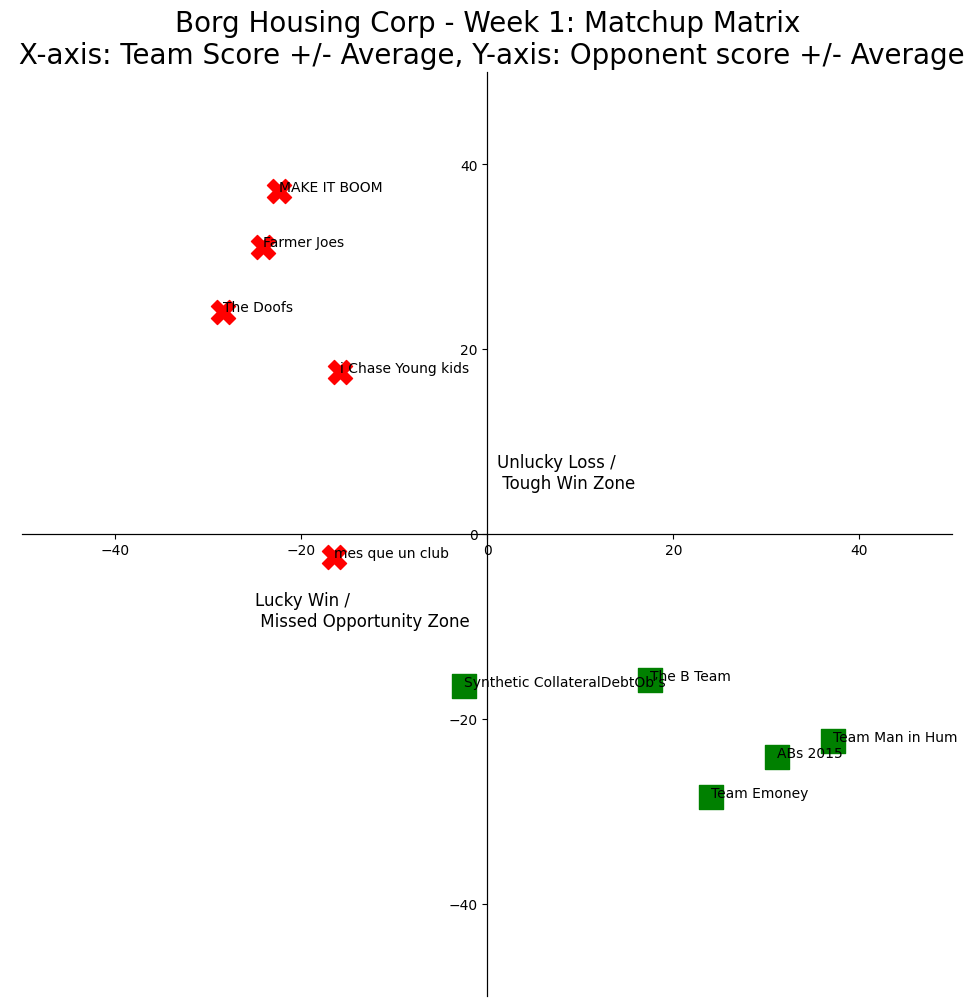

In [217]:
# Define plot size and autolayout
plt.rcParams["figure.figsize"] = [12, 12]
#plt.rcParams["figure.autolayout"] = True

# Define the subplot
fig, ax = plt.subplots()


# Plot the data
plt.scatter(away_win_df['Score1']- average_score, away_win_df['Score2'] - average_score, marker='s', c='green', s=300)
plt.scatter(away_loss_df['Score1'] - average_score, away_loss_df['Score2'] - average_score, marker='X', c='red', s=300)
plt.scatter(home_win_df['Score2']- average_score, home_win_df['Score1'] - average_score, marker='s', c='green', s=300)
plt.scatter(home_loss_df['Score2'] - average_score, home_loss_df['Score1']- average_score, marker='X', c='red', s=300)

# Loop through and annotate the away team names on the chart
for name in range(0, 10):
    try:
        plt.annotate(away_win_df['Name1'][name], (away_win_df['Score1'][name] - average_score, away_win_df['Score2'][name] - average_score), fontsize=10)
    except:
        pass
    try:
        plt.annotate(away_loss_df['Name1'][name], (away_loss_df['Score1'][name] - average_score, away_loss_df['Score2'][name] - average_score), fontsize=10)
    except:
        pass
    try:
        plt.annotate(home_win_df['Name2'][name], (home_win_df['Score2'][name] - average_score, home_win_df['Score1'][name] - average_score), fontsize=10)
    except:
        pass
    try:
        plt.annotate(home_loss_df['Name2'][name], (home_loss_df['Score2'][name] - average_score, home_loss_df['Score1'][name] - average_score), fontsize=10)
    except:
        pass


# Define axes' ranges - make this dynamic later
plt.xlim((-50, 50))
plt.ylim((-50, 50))


# Move left y-axis and bottom x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_position('center')
ax.spines['right'].set_position('center')

# Annotate the quadrants
plt.annotate("Unlucky Loss /\n Tough Win Zone", (1,5), fontsize=12);
plt.annotate("Lucky Win /\n Missed Opportunity Zone", (-25, -10), fontsize=12);

# Chart title
plt.title(
    f"Borg Housing Corp - Week {1}: Matchup Matrix\n X-axis: Team Score +/- Average, Y-axis: Opponent score +/- Average",
    fontdict={'fontsize':20});